In [127]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from pathlib import Path
import math
from source.side import Side
from source.dice import Dice
from source.dot import Dot
from source.isCircle import isCircle

# from ipynb.fs.full.functions import isCircle
from source.clustering import distSquare
# good
"2024-06-08_23-37-01_original" # 6,6,2
"2024-06-09_01-02-59_original" # 3,6,5
"2024-06-09_07-44-39_original" # 6,4,5
"2024-05-07_16-07-07_original"
"2024-06-09_07-06-07_original"
'2024-06-09_07-06-07_original'
"2024-06-09_05-36-23_original"
"2024-06-09_05-09-08_original"
"2024-06-08_22-32-54_original"
"2024-06-08_22-48-25_original"
"2024-06-09_07-04-58_original"
# bad
"2024-05-08_10-09-13_original"
"2024-05-09_05-55-43_original"
"2024-05-09_04-54-21_original"

imageName = "2024-06-08_20-16-57_original"
writeToFile = True
outputFolder = f'./data/{imageName}'
diceWidth = 40

# original = cv.imread(f'./data/original/{imageName}.png')
original = cv.imread(f'./newData/{imageName}.png', cv.IMREAD_GRAYSCALE)

assert original is not None, "file could not be read"

if(writeToFile):
    Path(outputFolder).mkdir(parents=True, exist_ok=True)

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

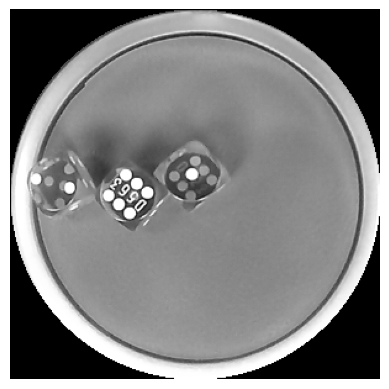

In [128]:
def crop_ring(image, crop_width, crop_height, center):
    center_y, center_x = center

    start_x = max(center_x - crop_width // 2, 0)
    start_y = max(center_y - crop_height // 2, 0)
    end_x = start_x + crop_width
    end_y = start_y + crop_height

    # Crop the image
    cropped_image = image[start_y:end_y, start_x:end_x]

    return cropped_image

ringCenter = (250, 325)
radius = 150
radiusSquared = radius ** 2
center_y, center_x = ringCenter

original = crop_ring(original, radius * 2, radius* 2, ringCenter)
height, width = original.shape

img = original.copy()
height, width = img.shape
center_y, center_x = (height //2, width//2)
Y, X = np.ogrid[:height, :width]
distance_from_center = (X - center_x) ** 2 + (Y - center_y) ** 2
mask = distance_from_center >= radiusSquared
img[mask] = 0


plt.imshow(img, cmap='gray')
plt.axis("off")

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

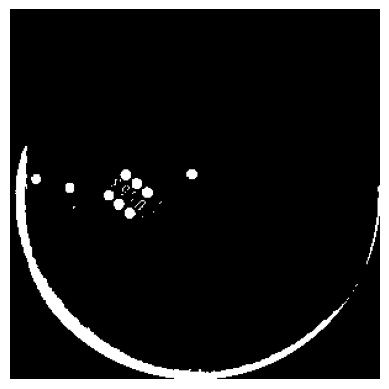

In [129]:
onlyWhite = img.copy()

non_white_mask = onlyWhite <= 250
reverse_mask = ~non_white_mask
# Set all non-white pixels to black (0)
onlyWhite[non_white_mask] = 0
onlyWhite[reverse_mask] = 255

if(writeToFile):
    cv.imwrite(f'{outputFolder}/whitePixels.png', onlyWhite)

plt.imshow(onlyWhite, cmap='gray')
plt.axis('off')
            

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

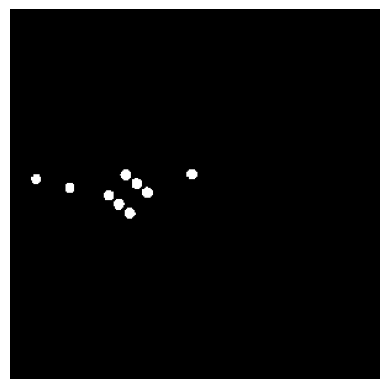

In [130]:
# [0,1,0,0,0,0 ...]
isPixelChecked = np.zeros((height, width), dtype=np.bool)


def findSector(point, onlyWhite):
    arr = [point]
    cluster = []
    while len(arr):
        poped = arr.pop()
        y,x = poped

        if y == height:
            continue
        if x == width:
            continue
        if x < 0:
            continue
        if y < 0:
            continue

        if isPixelChecked[y, x] == 0:
            if onlyWhite[y, x] == 255:
                cluster.append(poped)
                isPixelChecked[y, x] = 1

                arr.append((y, x + 1))
                arr.append((y, x - 1))
                arr.append((y + 1, x))
                arr.append((y - 1, x))
                
    return cluster

dots: list[Dot] = []
for y in range(0, height):
    for x in range(0, width):
        if onlyWhite[y, x] == 255 and isPixelChecked[y, x] == 0:
            pixels = findSector((y, x), onlyWhite)
            dots.append(Dot(pixels))

validDots = []

for dot in dots:
    dot.calc()

for dot in dots:
    pixelsLen = len(dot.pixels)
    
    if pixelsLen <= 15 or pixelsLen >100:
        for pixel in dot.pixels:
            y,x = pixel
            onlyWhite[y, x] = 0
        continue
    
    if dot.w > 20 or dot.h > 20:
        for pixel in dot.pixels:
            y,x = pixel
            onlyWhite[y, x] = 0
        continue
    
    validDots.append(dot)
    
dots = validDots
validDots = []

for dot in dots:
    if isCircle(dot.dimension(), onlyWhite):
        validDots.append(dot)
    else:
        for pixel in dot.pixels:
            y,x = pixel
            onlyWhite[y, x] = 0
            
            
dots = validDots
validDots = []  
    
    
if writeToFile:
    cv.imwrite(f"{outputFolder}/dots.png", onlyWhite)

plt.imshow(onlyWhite, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

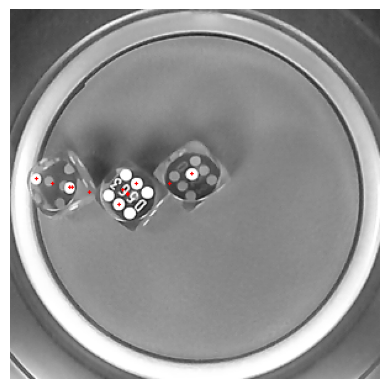

In [131]:
tmpImg2 = cv.cvtColor(original, cv.COLOR_GRAY2RGB)

length = len(dots)

all = []
for i in range(0, length):
    for j in range(0, length):
        dot1 = dots[i]
        dot2 = dots[j]

        cy = (dot1.cy + dot2.cy) / 2
        cx = (dot1.cx + dot2.cx) / 2
        all.append((cy, cx))


def findSector(point, isPixelChecked, onlyWhite):
    arr = [point]
    pixels = []
    while len(arr):
        y, x = arr.pop()

        if y >= height:
            continue
        if x >= width:
            continue
        if x < 0:
            continue
        if y < 0:
            continue

        if isPixelChecked[y, x] == 0:
            if onlyWhite[y, x] == 255:
                isPixelChecked[y, x] = 1
                pixels.append((y, x))
                arr.append((y, x + 1))
                arr.append((y, x - 1))
                arr.append((y + 1, x))
                arr.append((y - 1, x))

    cx = 0
    cy = 0
    for p in pixels:
        cx += p[1]
        cy += p[0]

    if len(pixels) == 0:
        return (0, 0)

    cx /= len(pixels)
    cy /= len(pixels)
    return (cy, cx)


def find_angle_between_points(p1, p2):
    y1, x1 = p1
    y2, x2 = p2
    dx = x2 - x1
    dy = y2 - y1

    angle_radians = math.atan2(dy, dx)

    angle_degrees = math.degrees(angle_radians)

    return angle_degrees


def are_opposite_angles(angle1, angle2, tolerance=20):
    angle1 = angle1 % 360
    angle2 = angle2 % 360

    difference = abs(angle1 - angle2)

    if difference > 180:
        difference = 360 - difference

    return 180 - tolerance <= difference <= 180 + tolerance


def checkDot(point, onlyWhite, dots: list[Dot]):
    y, x = point
    roundedY = round(y)
    roundedX = round(x)

    r = diceWidth / 2

    nearDots: list[Dot] = list(
        filter(lambda dot: distSquare(dot.centerPoint, point) < r * r, dots)
    )
    # for d in nearDots:
    #     d.printInfo()

    distances = []
    if len(nearDots) == 0:
        return -1

    if len(nearDots) % 2 == 0:
        if onlyWhite[roundedY, roundedX] != 0:
            return -1
    else:
        if onlyWhite[roundedY, roundedX] != 255:
            return -1

    for dot in nearDots:
        distances.append((math.sqrt(distSquare(dot.centerPoint, point)), dot))

    distances = sorted(distances, key=lambda x: x[0])
    d1 = distances[0]
    count = 0
    sectored = [[]]
    # print(distances)
    for d2 in distances:
        if abs(d1[0] - d2[0]) < 2:
            sectored[count].append(d2)
            continue
        sectored.append([d2])
        count = 1
        d1 = d2

    countDistances = []
    
    for s in sectored:
        countDistances.append(len(s))
    
    if (
        countDistances != [1]
        and countDistances != [2]
        and countDistances != [1, 2]
        and countDistances != [4]
        and countDistances != [2, 2]
        and countDistances != [1, 4]
        and countDistances != [1, 2, 2]
        and countDistances != [2, 4]
        and countDistances != [2, 2, 2]
    ):
        if len(distances) == 4:
            countDistances= [4]
            sectored = [[distances[0], distances[1],distances[2],distances[3]]]
        if len(distances) == 5:
            countDistances= [1,4]
            sectored = [[distances[0]], [distances[1],distances[2],distances[3],distances[4]]]
        if len(distances) == 6:
            countDistances= [6]
            sectored = [[distances[0], distances[1],distances[2],distances[3],distances[4],distances[5]]]
            
    

    for s in sectored:
        if len(s) <= 1:
            continue
        angles = [
            find_angle_between_points(point, item[1].centerPoint) % 360 for item in s
        ]
        countChecks = 0
        for index1, angle1 in enumerate(angles):
            check = 0
            for index2, angle2 in enumerate(angles):
                if index2 <= index1:
                    continue
                if are_opposite_angles(angle1, angle2):
                    check = 1

            countChecks += check
        if countChecks != len(s) / 2:
            return -1

    return


valid = []
for index, point in enumerate(all):
    # if index != 1:
    #     continue
    dotValue = checkDot(point, onlyWhite, dots)
    if dotValue != -1:
        valid.append((dotValue, index, point))
        color = (0, 0, 255)
        y, x = point
        roundedY = round(y)
        roundedX = round(x)
        tmpImg2 = cv.circle(tmpImg2, (roundedX, roundedY), 1, color, -1)

plt.imshow(cv.cvtColor(tmpImg2, cv.COLOR_BGR2RGB))
plt.axis("off")

In [132]:
len(valid)

25

126.44725392261095
97.48089989982608
30.20612463587592
1 0 147 133
1 1 21 137
1 2 50 144


(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

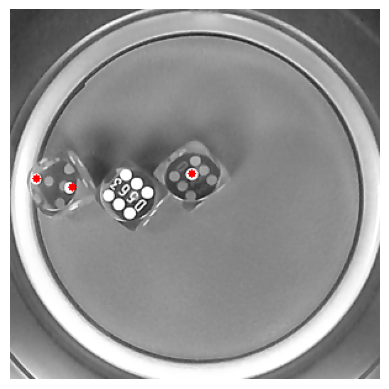

In [126]:
tmpImg2 = cv.cvtColor(original, cv.COLOR_GRAY2RGB)
validOnes = []
i=0
while i < len(valid):
    v1, _, p1 = valid[i]
    j = i + 1
    while j < len(valid):
        v2, _, p2 = valid[j]
        if(v2 != 1 or v1 != 1):
            j+=1
            continue
        print(math.sqrt(distSquare(p1,p2)))
        if distSquare(p1, p2) <= 4 * 4 and v1 == v2:
            valid.pop(j)
            j -= 1
        j += 1
    i += 1
    
for index, v in enumerate(valid):
    value,i,p = v
    if value == 1:
        validOnes.append(v)

for index, v in enumerate(validOnes):
    v, i, p = validOnes[index]
    color = (0, 0, 255)
    y, x = p
    roundedY = round(y)
    roundedX = round(x)
    print(v, index, roundedX, roundedY)
    tmpImg2 = cv.circle(tmpImg2, (roundedX, roundedY), 3, color, -1)

plt.imshow(cv.cvtColor(tmpImg2, cv.COLOR_BGR2RGB))
plt.axis("off")

156.39008566389515
120.65867105407659
2073.2893869456375
718.9734546412013
6657.100238387273
4602.312593078963
2715.1611836934862
0.043730760342401545
8
119.1590844396124
4602.312593078963
2945.924842042086
1512.5693885389628
718.9734546412013
474.69203893538815
156.39008566389515
32.456960620799535
3340.902581076367
1498.034112377586
4963.796553525351
3191.510931248474
1640.8882917042686
32.43657618919623
3191.510931248474
1817.6252032430325
720.7985195811794
1498.034112377586
147.73325395097896
0.0
14
2963.1925843056742
1226.9189879644387
5676.125712201782
3757.581584909997
2045.0214293647673
0.004704580471218262
8
3757.581584909997
2237.4373518896464
978.6731522267694
1226.9189879644387
116.71614023448012
381.55172516621735
15988.908024569253
12761.756255611419
9502.525845279913
12761.756255611419
9933.004380925024
7127.5699264758705
381.55172516621735
4064.620297734623
11744.831872896077
8959.08604748327
6225.656383721579
8959.08604748327
6571.740116341899
4292.1064084625605
0.0
11

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

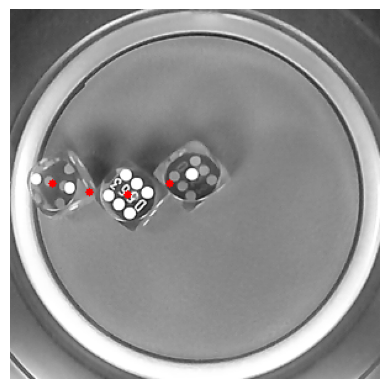

In [112]:
tmpImg2 = cv.cvtColor(original, cv.COLOR_GRAY2RGB)
isInvalid = False

i = 0
while i < len(valid):
    v1, _, p1 = valid[i]
    j = i + 1
    while j < len(valid):
        v2, _, p2 = valid[j]
        print(distSquare(p1, p2))
        if distSquare(p1, p2) <= 4 * 4 and v1 == v2:
            print(j)
            valid.pop(j)
            j -= 1
        j += 1
    i += 1

valid = sorted(valid, key=lambda x: -x[0])
i = 0
while i < len(valid):
    v1, _, p1 = valid[i]
    j = i + 1
    r = diceWidth / 2
    while j < len(valid):
        v2, _, p2 = valid[j]
        if distSquare(p1, p2) < r * r:
            if v1 == v2:
                isInvalid = True
            if v1 > v2:
                valid.pop(j)
                j -= 1
        j += 1
    i += 1

for index, v in enumerate(valid):
    v, i, p = valid[index]
    color = (0, 0, 255)
    y, x = p
    roundedY = round(y)
    roundedX = round(x)
    print(v, index, roundedX, roundedY)
    tmpImg2 = cv.circle(tmpImg2, (roundedX, roundedY), 3, color, -1)

plt.imshow(cv.cvtColor(tmpImg2, cv.COLOR_BGR2RGB))
plt.axis("off")

2
1
1
0
validFiltered: 
{(2, 22, (140.97549019607843, 34.333333333333336)), (6, 8, (149.50806451612902, 95.03569539925965)), (2, 14, (140.8875437180522, 128.98574118913103))}
validFiltered: 
[(2, 22, (140.97549019607843, 34.333333333333336)), (6, 8, (149.50806451612902, 95.03569539925965)), (2, 14, (140.8875437180522, 128.98574118913103))]
valid: 
[]
2 0 34 141
6 1 95 150
2 2 129 141


(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

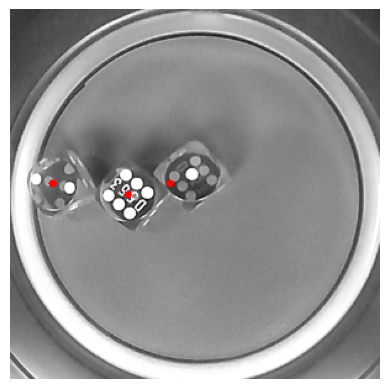

In [113]:
tmpImg2 = cv.cvtColor(original, cv.COLOR_GRAY2RGB)

tmpValid = valid.copy()
tmpValid = sorted(tmpValid, key=lambda x: x[2][0])

validFiltered = set()
popFront = True

for d in dots:
    d.arr = []

i = 0
while i < len(valid):
    r = diceWidth / 2
    v, _, p = valid[i]

    def filterFunc(dot: Dot):
        return distSquare(p, dot.centerPoint) < r * r

    nearDots: list[Dot] = list(filter(filterFunc, dots))
    for d in nearDots:
        d.arr.append(i)

    i += 1


def sortByX(d: Dot):
    return d.centerPoint[1]


def sortByY(d: Dot):
    return d.centerPoint[0]


dots = sorted(dots, key=sortByX)

if len(dots[0].arr) == 1:
    print(dots[0].arr[0])
    validFiltered.add(valid[dots[0].arr[0]])
if len(dots[-1].arr) == 1:
    print(dots[-1].arr[0])
    validFiltered.add(valid[dots[-1].arr[0]])

dots = sorted(dots, key=sortByY)
if len(dots[0].arr) == 1:
    print(dots[0].arr[0])
    validFiltered.add(valid[dots[0].arr[0]])
if len(dots[-1].arr) == 1:
    print(dots[-1].arr[0])
    validFiltered.add(valid[dots[-1].arr[0]])

print("validFiltered: ")
print(validFiltered)

validFiltered = list(validFiltered)
for d in dots:
    d.arr = []


i = 0
while i < len(validFiltered):
    r = diceWidth / 2
    v, _, p = validFiltered[i]

    def filterFunc(dot: Dot):
        return distSquare(p, dot.centerPoint) < r * r

    nearDots: list[Dot] = list(filter(filterFunc, dots))

    for d in nearDots:
        d.arr.append(i)

    i += 1

i = 0
while i < len(valid):
    v, _, p = valid[i]

    def filterFunc(dot: Dot):
        return distSquare(p, dot.centerPoint) < r * r

    nearDots: list[Dot] = list(filter(filterFunc, dots))
    check = False
    for d in nearDots:
        if len(d.arr) != 0:
            check = True
    if check:
        valid.pop(i)
        continue

    i += 1

print("validFiltered: ")
print(validFiltered)

print("valid: ")
print(valid)

valid = valid + validFiltered


for index, v in enumerate(valid):
    v, i, p = valid[index]
    color = (0, 0, 255)
    y, x = p
    roundedY = round(y)
    roundedX = round(x)
    print(v, index, roundedX, roundedY)
    tmpImg2 = cv.circle(tmpImg2, (roundedX, roundedY), 3, color, -1)

result = list(
    map(
        lambda v: f"{v[0]}",
        valid,
    )
)

plt.imshow(cv.cvtColor(tmpImg2, cv.COLOR_BGR2RGB))
plt.axis("off")